In [2]:
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset
from torchvision.transforms import CenterCrop

import os

In [4]:
# Определяем Размеры изображения
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# Определяем трешхолд для отфильтровывания маловероятных предсказаний
THRESHOLD = 0.5
# Определяем базовую директорию
BASE_FOLDER = os.curdir
MODEL_FOLDER = os.path.join(BASE_FOLDER, "models")
# Определяем режим работы
WITH_MASKS = False
MODEL_TYPE = "_disease_segmentation" + ("_withmasks" if WITH_MASKS else "")
# Определяем пути к файлам
MASKMODEL_PATH = os.path.join(MODEL_FOLDER, "unet_leaf_segmentation.pth")
MODEL_PATH = os.path.join(MODEL_FOLDER, "unet" + MODEL_TYPE + ".pth")
IMAGES_FOLDER = os.path.join(BASE_FOLDER, "images_for_test")

In [5]:
# Определяем девайс для работы
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [6]:
transformes = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((INPUT_IMAGE_HEIGHT,
    INPUT_IMAGE_WIDTH)),
    torchvision.transforms.ToTensor()])

In [7]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # Объявляем линейные слои с прослойкой из relu
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # Применяем описанный выше блок
        return self.conv2(self.relu(self.conv1(x)))
    
class Encoder(Module):
    def __init__(self, in_channels=3, channels=(16, 32, 64)):
        super().__init__()
        # Объявляем блоки энкодера с макспуллом
        channels = (in_channels,) + channels
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # Объявляем выходы блоков
        blockOutputs = []
        # Проходимся по блокам энкодера
        for block in self.encBlocks:
            # Пропускаем х через очередной блок
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # Возвращаем список выходов
        return blockOutputs
    
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # Проходимся по каждому из каналов
        for i in range(len(self.channels) - 1):
            # передаем входные данные через блоки дискретизатора
            x = self.upconvs[i](x)
            # пропускаем через блок декодера
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # Возвращаем итог
        return x
    def crop(self, encFeatures, x):
        # Оберзаем картинку
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # возвращаем обрезанную картинку
        return encFeatures

class UNet(Module):
    def __init__(self, inChannels=3, encChannels=(16, 32, 64),
        decChannels=(64, 32, 16),
        nbClasses=1, retainDim=True,
        outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # Объявляем энкодер и декодер
        self.encoder = Encoder(inChannels, encChannels)
        self.decoder = Decoder(decChannels)
        encChannels = (inChannels,) + encChannels
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
    def forward(self, x):
        # Пропускаем x через энкодер
        encFeatures = self.encoder(x)
        # Пропускаем результат через декодер
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        map = self.head(decFeatures)
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # Возвращаем полученную маску
        return map

In [8]:
unet = torch.load(MODEL_PATH).to(DEVICE)
masknet = None
if WITH_MASKS:
    masknet = torch.load(MASKMODEL_PATH)

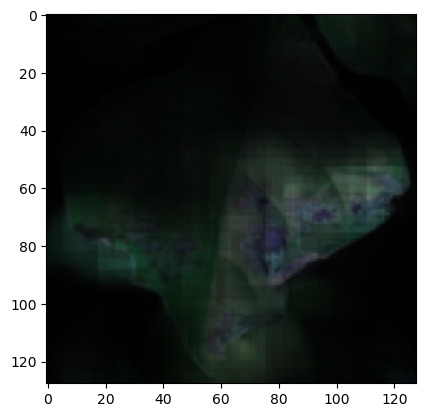

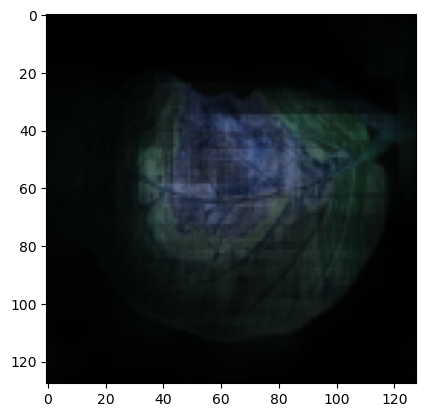

In [9]:
images = sorted(list(paths.list_images(IMAGES_FOLDER)))
for single_image_path in images:
    image = cv2.imread(single_image_path)
    image = transformes(image)
    img = image[None, :].to(DEVICE)
    if WITH_MASKS:
        img = torch.cat([image[None, :], masknet(image[None, :])], dim=1)
    pred = unet(img)
    ns = torch.sigmoid(pred.detach())
    ns = ns.to('cpu').numpy()[0]
    image = image.to('cpu').detach()

    plt.imshow(np.transpose(image * ns, axes=[1, 2, 0]))
    plt.show()